# Medical Image Classification

The goal of this notebook is to classify the ches X-ray image into two classes (Normal or pneumonia).

The model uses inceptionV3 network to extract features from the X-ray images and classify it into its respective classes.

In [3]:
import sys
import os
import argparse

import random

import time
import datetime

from collections import Counter

import numpy as np
import pandas as pd

import shutil
#from tqdm import tqdm

import inspect
import gc

import re

from PIL import Image
#import cv2

import keras

from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense


from keras.applications.inception_v3 import InceptionV3


from keras.constraints import maxnorm


from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop


import keras.backend.tensorflow_backend as K
K.set_image_dim_ordering('tf')


from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


#from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf



from IPython.display import display

#import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [4]:
#setting the input and output directory
input_directory = r"data/input/"
output_directory = r"data/output/"

training_dir = input_directory + r"train"
validation_dir = input_directory + r"val"
testing_dir = input_directory + r"test"

The dataset is divided into Train, Validation and test directory. Using ImageDataGenerator class we read into train, test and validation. The imagedatagenerator is an image preprocessing class that performs all the preprocessing steps such as data augmentation for training, rescaling, cropping. The ImageDataGenerator accepts the original data, randomly transforms it, and returns only the new, transformed data. 

In [5]:
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = "categorical"
# class_mode = "binary"


train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,validation_split=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=624,
    shuffle = False)

Found 4059 images belonging to 2 classes.
Found 4059 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


The imageDataGenerator class found 4059 images for training, 4059 images for validation and 624 images for testing. Since the training data is not sufficient enough to train an image classifier model from scratch, the transfer learning approach is used to extract features from the images and we train our model on top of it with those features.

In [17]:
main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"



model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

os.mkdir(model_dir)
#create_directory(model_dir, remove=True)
os.mkdir(log_dir)

model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

In [18]:


checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)


tensorboard = TensorBoard(
    log_dir=log_dir,
    batch_size=batch_size,
    update_freq = 'batch')


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)


#-----------------------------------------------------------------------------------------------------------------#
callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
# callbacks = [checkpoint, tensorboard]
#-----------------------------------------------------------------------------------------------------------------#


In [15]:
# Load and configure model InceptionV3 for fine-tuning with new class labels
def get_model():    
    
#     base_model = InceptionV3(weights=None, include_top=False)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    x = base_model.output
    
    x = Dropout(0.5)(x)
    
    x = GlobalAveragePooling2D()(x)
    #x=Flatten()(x)
    x = Dense(512, activation='relu')(x)
    # x = Dense(1024, activation='relu')(x)
    
    x = BatchNormalization()(x)
    
# #     predictions = Dense(2, activation='sigmoid')(x) 
    
    predictions = Dense(2, activation='softmax')(x) 
    
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    
    for layer in base_model.layers:
        layer.trainable = False
        
        
#     for layer in model.layers[:249]:
#         layer.trainable = False
#     for layer in model.layers[249:]:
#         layer.trainable = True
        
    
    model.summary()
        
    return model

In [16]:
print("Getting Base Model")
model = get_model()
#model = get_conv_model()
# model = keras.models.load_model("data/output/models/2018-12-15 00-26-45/13-val_acc-0.70-val_loss-0.58.hdf5")

#print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

    
print("Starting Trainning Model", date_time(1))


steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)



# lr = 0.00001
# optimizer=optimizers.Adam(lr=lr)



optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 10

Getting Base Model
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
_________________________________________________________________________

In [16]:



model.compile(optimizer, loss=loss, metrics=metrics)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    )

print("Completed Model Trainning", date_time(1))


Epoch 1/10
25/25 [==============================] - 158s 6s/step - loss: 0.8925 - acc: 0.6389 - val_loss: 0.4688 - val_acc: 0.9547
Epoch 2/10
25/25 [==============================] - 168s 7s/step - loss: 0.3502 - acc: 0.8926 - val_loss: 0.2244 - val_acc: 0.9364
Epoch 3/10
25/25 [==============================] - 170s 7s/step - loss: 0.2009 - acc: 0.9603 - val_loss: 0.1761 - val_acc: 0.9510
Epoch 4/10
25/25 [==============================] - 156s 6s/step - loss: 0.1351 - acc: 0.9680 - val_loss: 0.3458 - val_acc: 0.9547
Epoch 5/10
25/25 [==============================] - 156s 6s/step - loss: 0.1096 - acc: 0.9665 - val_loss: 0.2613 - val_acc: 0.9549
Epoch 6/10
25/25 [==============================] - 154s 6s/step - loss: 0.0897 - acc: 0.9724 - val_loss: 0.1779 - val_acc: 0.9295
Epoch 7/10
25/25 [==============================] - 154s 6s/step - loss: 0.0897 - acc: 0.9716 - val_loss: 0.2036 - val_acc: 0.9537
Epoch 8/10
25/25 [==============================] - 154s 6s/step - loss: 0.0788 - a

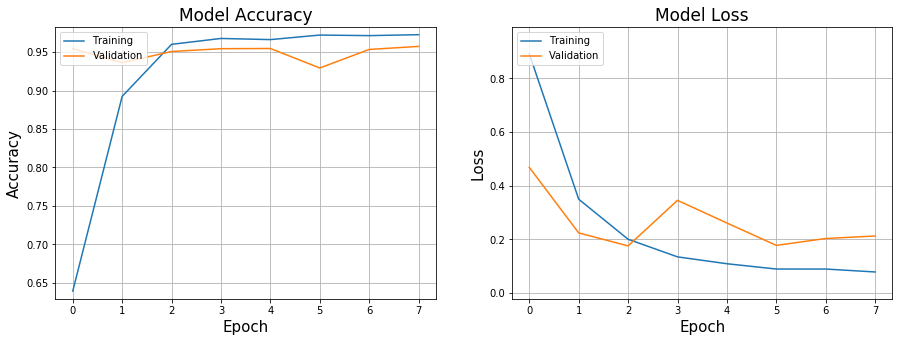

In [17]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

In [6]:
dir_name = r"data/output/models/"
dirs = os.listdir(dir_name)
for i in range(len(dirs)):
    print(i, dirs[i])

0 2019-09-21 14-29-05
1 2019-09-21 13-49-36
2 2019-09-21 15-04-31
3 2019-09-21 15-07-21
4 2019-09-21 13-06-44
5 2019-09-21 15-07-44


In [8]:
cur_dir =dir_name+dirs[5]+"/"
model_names = os.listdir(cur_dir)
for i in range(len(model_names)):
    print(i, model_names[i])

0 08-val_acc-0.96-val_loss-0.21.hdf5
1 05-val_acc-0.95-val_loss-0.26.hdf5
2 01-val_acc-0.95-val_loss-0.47.hdf5


In [9]:
model_file = cur_dir+model_names[0]

print(model_file)

data/output/models/2019-09-21 15-07-44/08-val_acc-0.96-val_loss-0.21.hdf5


In [10]:
model=keras.models.load_model(model_file)

W0921 15:35:03.850136 139851369842496 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0921 15:35:03.887052 139851369842496 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0921 15:35:03.902122 139851369842496 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0921 15:35:03.902683 139851369842496 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0921 15:35:03.903184 1398513698

In [11]:
print('results: ')
print(model.evaluate(test_generator))

results: 
1/1 [==============================] - 17s 17s/step
[2.1395747661590576, 0.6474359035491943]


# Model evaluation

The model performs well and shows a good performance in classifying the validation dataset but performs poor in testing data. This is due to the fact that variation in training data for both the class is very high. The training data for Normal class is high whereas the number of training data in the pneumonic affected data is low. This is what is called class imabalance problem in machine learning. So the model is more biased towards the class with more dataset while classifying the images.

In order to tackle the class imbalance problem we add weights to the class while training the model so that the model gives equal importance to both the classes.

In [12]:
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

In [13]:
class_weight = get_weight(train_generator.classes)
class_weight

array([11.0298913 ,  0.52374194])

In [19]:


model.compile(optimizer, loss=loss, metrics=metrics)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=validation_generator,class_weight=class_weight,
    validation_steps=validation_steps, 
    )

print("Completed Model Trainning", date_time(1))


W0921 15:36:59.354095 139851369842496 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/callbacks.py:1122: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0921 15:36:59.354942 139851369842496 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/callbacks.py:1125: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/10
25/25 [==============================] - 169s 7s/step - loss: 0.8206 - acc: 0.6501 - val_loss: 0.2939 - val_acc: 0.9542
Epoch 2/10
25/25 [==============================] - 150s 6s/step - loss: 0.3540 - acc: 0.8895 - val_loss: 0.2194 - val_acc: 0.9549
Epoch 3/10
25/25 [==============================] - 156s 6s/step - loss: 0.1957 - acc: 0.9576 - val_loss: 0.1470 - val_acc: 0.9490
Epoch 4/10
25/25 [==============================] - 155s 6s/step - loss: 0.1302 - acc: 0.9670 - val_loss: 0.1956 - val_acc: 0.9367
Epoch 5/10
25/25 [==============================] - 156s 6s/step - loss: 0.1093 - acc: 0.9667 - val_loss: 0.2329 - val_acc: 0.9537
Epoch 6/10
25/25 [==============================] - 161s 6s/step - loss: 0.0951 - acc: 0.9699 - val_loss: 0.3408 - val_acc: 0.9547
Epoch 7/10
25/25 [==============================] - 157s 6s/step - loss: 0.0924 - acc: 0.9702 - val_loss: 0.4017 - val_acc: 0.9554
Epoch 8/10
25/25 [==============================] - 155s 6s/step - loss: 0.0882 - a

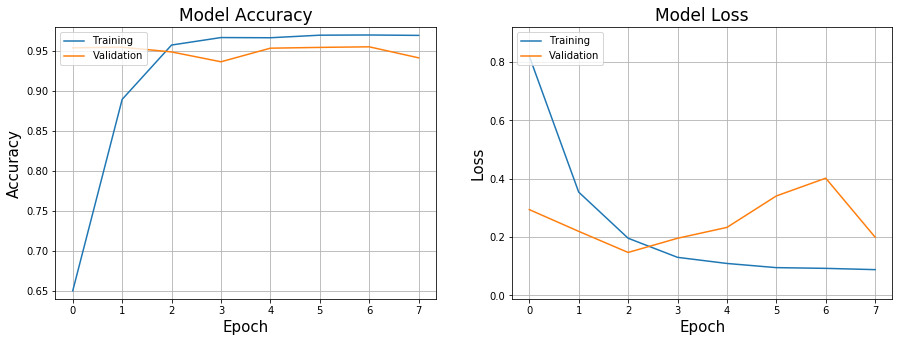

In [20]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()